# Navier Stokes in a pipe flow (stationary 2D) with soft constraints (PINN & SPINN)

We solve the stationary Navier Stokes PDE:

$$
\begin{cases}
\nabla\cdot\mathbf{u}=0,\\
(\mathbf{u}\cdot\nabla)\mathbf{u} + \frac{1}{\rho}\nabla p - \theta \nabla^2\mathbf{u}=0.
\end{cases}
$$

This becomes in 2D, with $\mathbf{u}=\begin{pmatrix}u_x \\ u_y\end{pmatrix}$


$$
\begin{cases}
\frac{\partial}{\partial x} u_x + \frac{\partial}{\partial y} u_y = 0 \\
\begin{pmatrix}u_x\frac{\partial}{\partial x} u_x + u_y\frac{\partial}{\partial y} u_x \\
u_x\frac{\partial}{\partial x} u_y + u_y\frac{\partial}{\partial y} u_y  \end{pmatrix} +
\frac{1}{\rho} \begin{pmatrix} \frac{\partial}{\partial x} p \\ \frac{\partial}{\partial y} p \end{pmatrix}
- \theta
\begin{pmatrix}
\frac{\partial^2}{\partial x^2} u_x + \frac{\partial^2}{\partial y^2} u_x \\
\frac{\partial^2}{\partial x^2} u_y + \frac{\partial^2}{\partial y^2} u_y
\end{pmatrix} = 0\\
\end{cases}
$$


With the boundary condition:
$$
\begin{cases}
u(x, \frac{d}{2}) = -u(x, \frac{d}{2})=0, \forall x \text{ (boundary condition) }\\
p(x_{min}, y)=0 \text{ and } p(x_{max}, y)=0.1, \forall y \text{ (boundary condition) }
\end{cases}
$$

The domain is defined with $x\in[0,L]$ and $y\in[-R, R]$. __Note__ that because of the central symmetry with respect to the centerline of the tube, we only consider the $y$ axis which will represent the cross section

This notebook aims at reproducing the example of section 3.1 of [*Surrogate modeling for fluid flows based on physics-constrained deep learning without simulation data*, Sun et al. 2020](https://www.sciencedirect.com/science/article/pii/S004578251930622X).

__However, the constraints are set up differently, i.e., as a penalizing loss term rather than a (soft constraint) rather than a term multiplying the model output (hard constraint, as proposed in the article).__


To solve the PDE, we use both a classical PINN and a [Separable PINN](https://openreview.net/pdf?id=dEySGIcDnI) approach implemented in jinns.

## The PINN approach

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Import our package

In [2]:
import jinns

Import other dependencies

In [3]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
import matplotlib.pyplot as plt

key = random.PRNGKey(2)

Create the neural network architecture for the PINN with `equinox`. We have a PINN which outputs the velocity field `u` (2D output) and concatenated to the pressure field `p` (1D output). So the total PINN output is of size 3.


In [11]:
key, subkey = random.split(key)


def u_p_output_transform(pinn_in, pinn_out, params):
    return jnp.concatenate(
        [
            pinn_out[0:2] * (R**2 - pinn_in[1] ** 2),
            (pinn_in[0] - xmin) / (xmax - xmin) * p_out
            + (xmax - pinn_in[0]) / (xmax - xmin) * p_in
            + (xmin - pinn_in[0]) * (xmax - pinn_in[0]) * pinn_out[2:3],
        ],
        axis=-1,
    )


u_p, u_p_init_nn_params = jinns.nn.PPINN_MLP.create(
    key=subkey,
    eqx_list_list=[
        (
            (eqx.nn.Linear, 2, 50),
            (jax.nn.tanh,),
            (eqx.nn.Linear, 50, 50),
            (jax.nn.tanh,),
            (eqx.nn.Linear, 50, 50),
            (jax.nn.tanh,),
            (eqx.nn.Linear, 50, 2),
        ),
        (
            (eqx.nn.Linear, 2, 50),
            (jax.nn.tanh,),
            (eqx.nn.Linear, 50, 50),
            (jax.nn.tanh,),
            (eqx.nn.Linear, 50, 50),
            (jax.nn.tanh,),
            (eqx.nn.Linear, 50, 1),
        ),
    ],
    eq_type="PDEStatio",
    output_transform=u_p_output_transform,
)

Create a DataGenerator object and set up some geometry. Following the [authors' implementation](https://github.com/Jianxun-Wang/LabelFree-DNN-Surrogate/blob/master/Tutorial/PipeFlow.ipynb), we set a pipe length $L=1$ and a pipe radius$R=0.05$. Following the authors, we also simplify the problem because of its geometry: the solution is symmetric with respect to the center of the pipe, at a given point $x\in[0, L]$. Therefore we only need one axis representing a pipe cross section and one axis representing the pipe length.

In [12]:
L = 1
R = 0.05

p_out = 0.0
p_in = 0.1

In [13]:
n = 10000
nb = 1000
omega_batch_size = 128
omega_border_batch_size = 128
dim = 2
xmin = 0
xmax = xmin + L
ymin = -R
ymax = ymin + 2 * R
method = "uniform"
key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDEStatio(
    key=subkey,
    n=n,
    nb=nb,
    omega_batch_size=omega_batch_size,
    omega_border_batch_size=omega_border_batch_size,
    dim=dim,
    min_pts=(xmin, ymin),
    max_pts=(xmax, ymax),
    method=method,
)

## Model parameters

Here we set the density $\rho=1$ and we simplify the problem with respect to the article: $\theta$ is the viscosity parameter which we fix and feed as input to the PINN as done in the article; $\theta=0.00061$

In [15]:
rho = 1.0
nu = 0.00061

Delta_p = 0.1
d = 2 * R

A set of parameters as required by the losses' `evaluate`. Here we adapt to the particular dynamic loss which requires the keys `u` and `p`.

In [16]:
init_params = jinns.parameters.Params(
    nn_params=u_p_init_nn_params,
    eq_params={"rho": rho, "nu": nu},
)

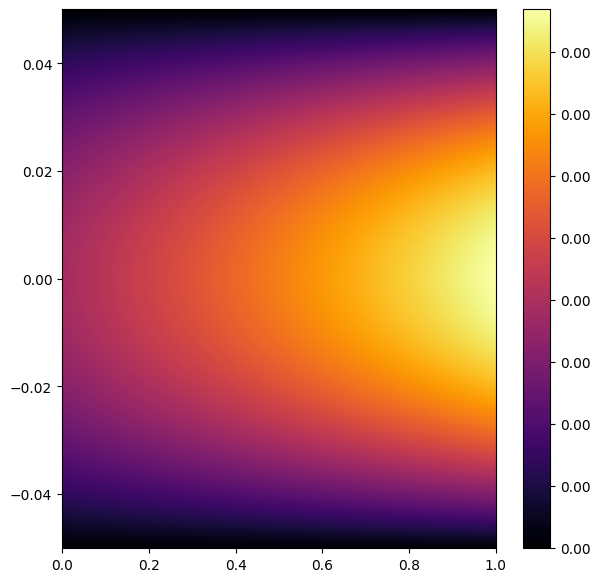

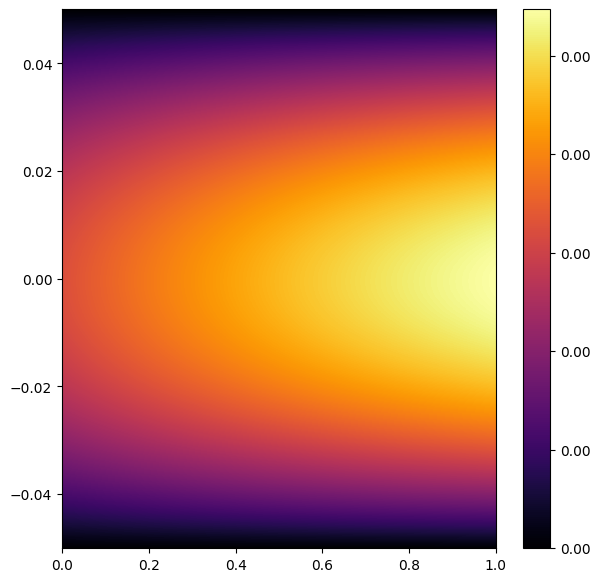

In [18]:
nx, ny = 1000, 1000
val_xy_data = [jnp.linspace(xmin, xmax, nx), jnp.linspace(ymin, ymax, ny)]

u_xinit = lambda x: u_p(x, init_params)[0]
jinns.plot.plot2d(fun=u_xinit, xy_data=val_xy_data, title="u_init(x)")

u_yinit = lambda x: u_p(x, init_params)[1]
jinns.plot.plot2d(fun=u_yinit, xy_data=val_xy_data, title="u_init(y)")

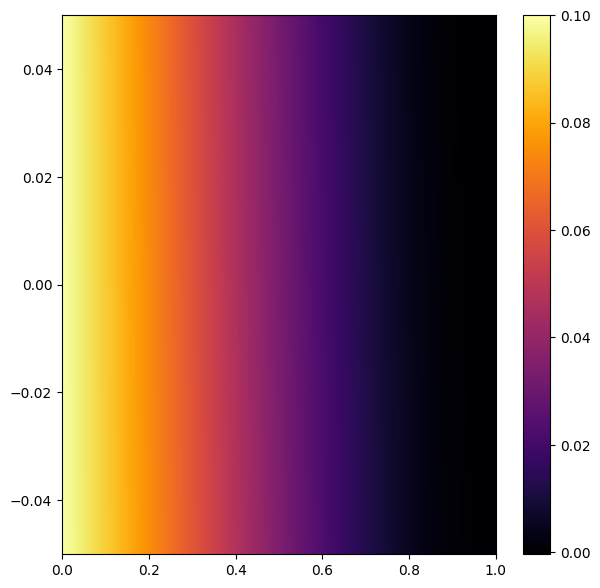

In [19]:
jinns.plot.plot2d(
    fun=lambda x: u_p(x, init_params)[2], xy_data=val_xy_data, title="p(x, y)"
)

## Analytical solution
In this case, the analytical solution is known:
$$
u_a = \frac{\Delta p}{2\theta\rho L}(\frac{d^2}{4} - y^2)
$$

Text(0.5, 1.0, 'True solution along a cross section')

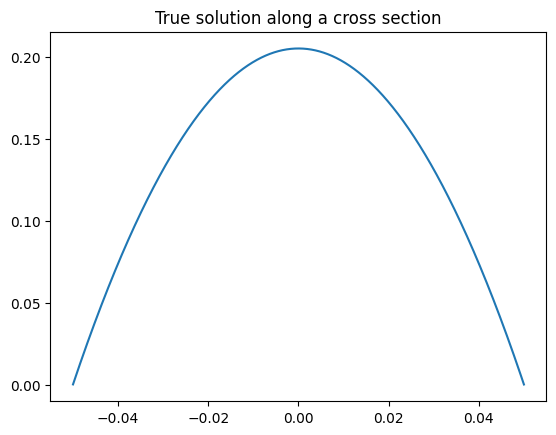

In [20]:
def u_true(x):
    return Delta_p / (2 * nu * rho * L) * ((d / 2) ** 2 - x**2)


plt.plot(
    train_data.omega[:, 1].sort(axis=0),
    vmap(u_true, (0), 0)(train_data.omega[:, 1].sort(axis=0)),
)
plt.title(r"True solution along a cross section")

## Loss construction

First create the boundary condition object that will enforce the boundary conditions. Note the facet order in 2D!

In [21]:
class DirichletFacets(jinns.loss.BoundaryConditionAbstract):
    """
    For the facet matching pattern, the last axis of `inputs` corresponds to
    0 -> "xmin"
    1 -> "xmax"
    2 -> "ymin"
    3 -> "ymax"
    """

    def equation_u(self, inputs, u, params):
        """
        Note that we must return a tuple for the facets
        Note that u is a SPINN so we get the dimension to apply the
        boundary condition with a ellipsis followed by a slice (eg [...,
        2:3])
        """
        u1 = u_p(inputs[..., 0], params)[..., 2:3]
        u2 = u_p(inputs[..., 1], params)[..., 2:3]
        u3 = u_p(inputs[..., 2], params)[..., 0:2]
        u4 = u_p(inputs[..., 3], params)[..., 0:2]
        return (u1, u2, u3, u4)

    def equation_f(self, _, __, **kwargs):
        f1 = jnp.array(p_in)
        f2 = jnp.array(p_out)
        f3 = jnp.array([0.0, 0.0])
        f4 = jnp.array([0.0, 0.0])
        return (f1, f2, f3, f4)


boundary_condition = DirichletFacets()

In [22]:
dyn_loss = jinns.loss.NavierStokesMassConservation2DStatio()

In [23]:
loss_weights = jinns.loss.LossWeightsPDEStatio(dyn_loss=1.0, boundary_loss=1.0)
loss = jinns.loss.LossPDEStatio(
    u=u_p,
    loss_weights=loss_weights,
    dynamic_loss=dyn_loss,
    boundary_condition=boundary_condition,
    params=init_params,
)

In [24]:
# Testing the loss function
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
key, subkey = random.split(key)
train_data, batch = train_data.get_batch()
losses, grads = losses_and_grad(init_params, batch=batch)


l_tot, dict_losses = losses
print(f"total loss: {l_tot:.2f}")
print(f"Individual losses: { {key: f'{val}' for key, val in dict_losses.items()} }")

total loss: 0.01
Individual losses: {'dyn_loss': '0.01', 'boundary_loss': '0.00'}


## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [16]:
params = init_params

In [17]:
# Optimizer
import optax

tx = optax.adamw(learning_rate=1e-3)

In [18]:
n_iter = int(10000)

In [19]:
key, subkey = random.split(key, 2)
params, total_loss_list, loss_by_term_dict, data, loss, _, _, _, _, _, _, _ = (
    jinns.solve(
        init_params=params, data=train_data, optimizer=tx, loss=loss, n_iter=n_iter
    )
)


Compilation took
 10.666682481765747 

[train] Iteration 0: loss value = 0.011892279610037804
[train] Iteration 1000: loss value = 0.0016277418471872807
[train] Iteration 2000: loss value = 0.00012427859473973513
[train] Iteration 3000: loss value = 1.5076714134920621e-06
[train] Iteration 4000: loss value = 1.945731131769435e-09
[train] Iteration 5000: loss value = 4.325700908580643e-10
[train] Iteration 6000: loss value = 1.1641679287244244e-10
[train] Iteration 7000: loss value = 6.655986317660734e-10
[train] Iteration 8000: loss value = 2.4928416969549616e-11
[train] Iteration 9000: loss value = 4.495268601800717e-10

Stopping main optimization loop, cause: max iteration is reached

Training took
 35.69675946235657 


Final iteration 10000: train loss value = 7.472259255791869e-09


## Results

Plot the loss values

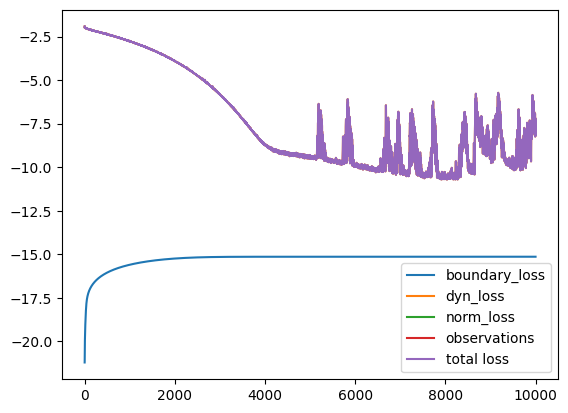

In [20]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

Plot the ODE solutions learned by the PINN

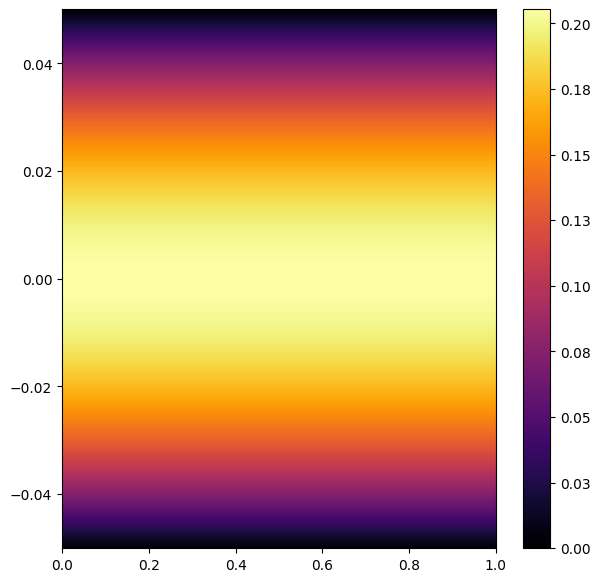

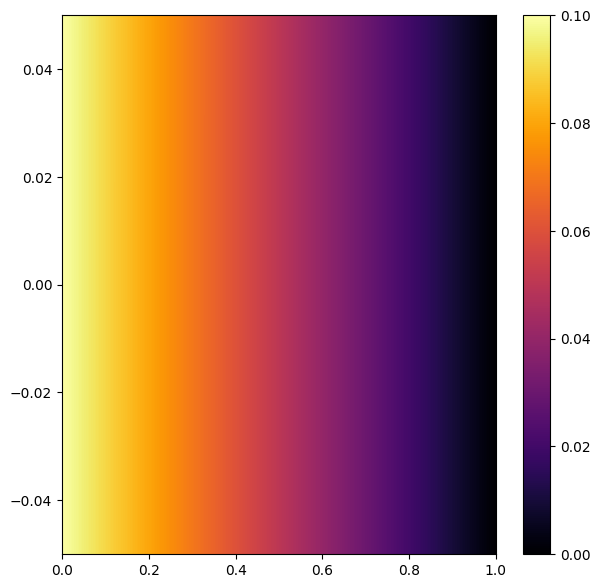

In [21]:
jinns.plot.plot2d(
    fun=lambda x: u_p(x, params)[0], xy_data=val_xy_data, title="u_est, x(x ,y)"
)

jinns.plot.plot2d(
    fun=lambda x: u_p(x, params)[2], xy_data=val_xy_data, title="p_est(x, y)"
)

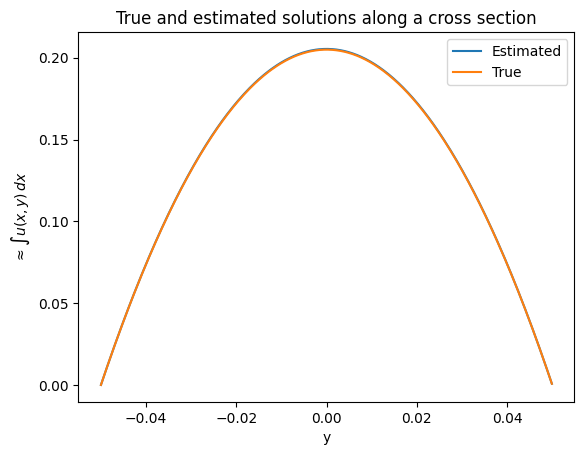

In [22]:
v_u_est_y = vmap(
    # compute average over array x with y_j fixed.
    lambda x, y_j: vmap(lambda z: u_p(jnp.stack([z, y_j], axis=-1), params)[0], 0, 0)(
        x
    ).mean(),
    (None, 0),
    0,
)


plt.plot(
    train_data.omega[::10, 1].sort(axis=0),
    v_u_est_y(
        train_data.omega[::10, 0].sort(axis=0), train_data.omega[::10, 1].sort(axis=0)
    ),
    label="Estimated",
)
plt.plot(
    train_data.omega[::10, 1].sort(axis=0),
    vmap(u_true, (0), 0)(train_data.omega[::10, 1].sort(axis=0)),
    label="True",
)
plt.xlabel("y")
plt.ylabel(r"$\approx \int u(x, y) \, dx$")
plt.legend()
plt.title(r"True and estimated solutions along a cross section")
plt.show()

## The SPINN approach

In [23]:
d_ = 2
r = 128
m = 2 + 1
eqx_list = (
    (eqx.nn.Linear, 1, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, r * m),
)
key, subkey = random.split(key)
u_p, u_p_init_nn_params = jinns.nn.SPINN_MLP.create(
    subkey, d_, r, eqx_list, "PDEStatio", m
)

In [24]:
n = 10000
nb = 10000
omega_batch_size = 50
omega_border_batch_size = 50
dim = 2
xmin = 0
xmax = xmin + L
ymin = -R
ymax = ymin + 2 * R

method = "uniform"
key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDEStatio(
    key=subkey,
    n=n,
    nb=nb,
    omega_batch_size=omega_batch_size,
    omega_border_batch_size=omega_border_batch_size,
    dim=dim,
    min_pts=(xmin, ymin),
    max_pts=(xmax, ymax),
    method=method,
)

In [25]:
init_params = jinns.parameters.Params(
    nn_params=u_p_init_nn_params,
    eq_params={"rho": rho, "nu": nu},
)

In [26]:
u_p_omega_boundary_fun = {
    "xmin": lambda x: p_in,
    "xmax": lambda x: p_out,
    "ymin": lambda x: jnp.array([0.0, 0.0]),
    "ymax": lambda x: jnp.array([0.0, 0.0]),
}
u_p_omega_boundary_condition = {
    "xmin": "dirichlet",
    "xmax": "dirichlet",
    "ymin": "dirichlet",
    "ymax": "dirichlet",
}
u_p_omega_boundary_dim = {
    "xmin": jnp.s_[2:3],
    "xmax": jnp.s_[2:3],
    "ymin": jnp.s_[0:2],
    "ymax": jnp.s_[0:2],
}
dyn_loss = jinns.loss.NavierStokesMassConservation2DStatio()
loss_weights = jinns.loss.LossWeightsPDEStatio(dyn_loss=1.0, boundary_loss=1.0)
loss = jinns.loss.LossPDEStatio(
    u=u_p,
    loss_weights=loss_weights,
    dynamic_loss=dyn_loss,
    omega_boundary_fun=u_p_omega_boundary_fun,
    omega_boundary_condition=u_p_omega_boundary_condition,
    omega_boundary_dim=u_p_omega_boundary_dim,
    params=init_params,
)

In [27]:
params = init_params

In [28]:
# Optimizer
import optax

tx = optax.adamw(learning_rate=1e-4)
n_iter = int(30000)
key, subkey = random.split(key, 2)

In [33]:
params, total_loss_list, loss_by_term_dict, data, loss, _, _, _, _, _, _, _ = (
    jinns.solve(
        init_params=params, data=train_data, optimizer=tx, loss=loss, n_iter=n_iter
    )
)


Compilation took
 18.891489267349243 

[train] Iteration 0: loss value = 0.1543404906988144
[train] Iteration 1000: loss value = 0.003331112675368786
[train] Iteration 2000: loss value = 0.0033396980725228786
[train] Iteration 3000: loss value = 0.003336780471727252
[train] Iteration 4000: loss value = 0.0033325247932225466
[train] Iteration 5000: loss value = 0.0033467072062194347
[train] Iteration 6000: loss value = 0.0033055024687200785
[train] Iteration 7000: loss value = 0.003211481496691704
[train] Iteration 8000: loss value = 0.002857150509953499
[train] Iteration 9000: loss value = 0.0015957264695316553
[train] Iteration 10000: loss value = 0.0006175743183121085
[train] Iteration 11000: loss value = 0.0008512639906257391
[train] Iteration 12000: loss value = 0.00014123431174084544
[train] Iteration 13000: loss value = 0.0016263923607766628
[train] Iteration 14000: loss value = 5.3588060836773366e-05
[train] Iteration 15000: loss value = 3.9910599298309535e-05
[train] Iteration

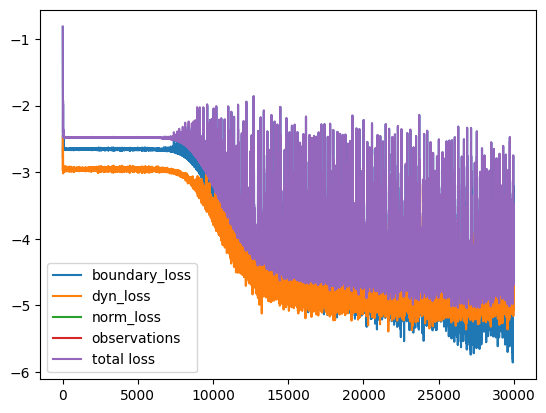

In [34]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

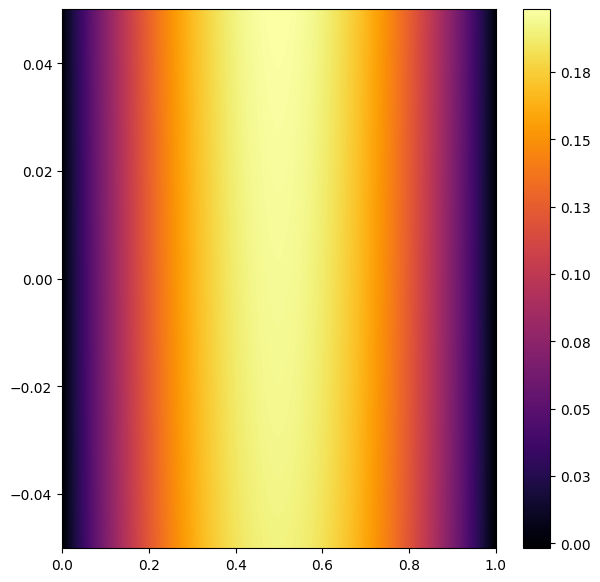

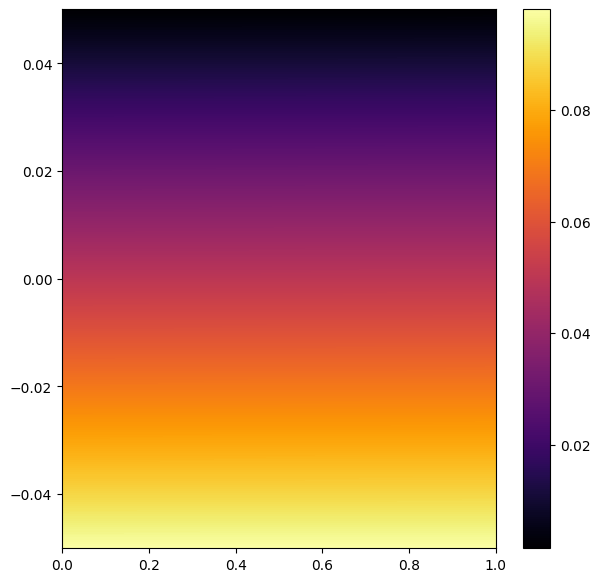

In [35]:
jinns.plot.plot2d(
    fun=lambda x: u_p(x, params)[..., 0:1],
    xy_data=val_xy_data,
    title="u_est, x(x ,y)",
    spinn=True,
)

jinns.plot.plot2d(
    fun=lambda x: u_p(x, params)[..., 2:3],
    xy_data=val_xy_data,
    title="p_est(x, y)",
    spinn=True,
)

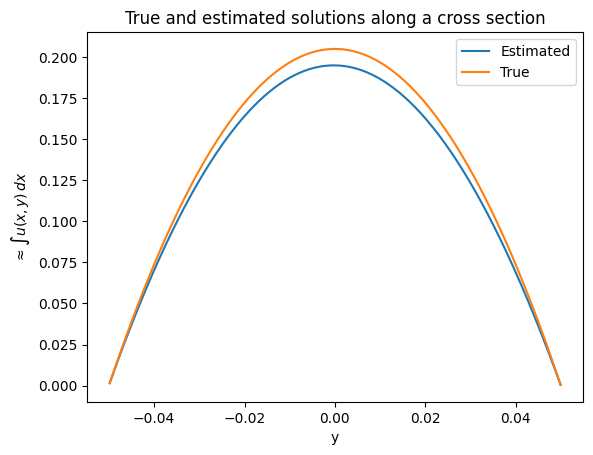

In [36]:
plt.plot(
    train_data.omega[::10, 1].sort(axis=0),
    jnp.mean(
        u_p(
            jnp.stack(
                [
                    train_data.omega[::10, 0].sort(axis=0),
                    train_data.omega[::10, 1].sort(axis=0),
                ],
                axis=-1,
            ),
            params,
        )[..., 0],
        axis=0,
    ),
    label="Estimated",
)
plt.plot(
    train_data.omega[::10, 1].sort(axis=0),
    vmap(u_true, (0), 0)(train_data.omega[::10, 1].sort(axis=0)),
    label="True",
)
plt.xlabel("y")
plt.ylabel(r"$\approx \int u(x, y) \, dx$")
plt.legend()
plt.title(r"True and estimated solutions along a cross section")
plt.show()

## Conclusion

We solved this simple Navier-Stokes problem with both SPINNs and PINNs. Both tend towards the correct solution but the SPINN approach is longer.

Higher dimensional problems should be investigated to really grasp to potential of SPINNs.